In [1]:
import sys,os,time

import tables as tb
import yaml
import numpy as np
from matplotlib import colors
norm = colors.LogNorm()
import matplotlib.pyplot as plt

import tjmonopix.tjmonopix
import tjmonopix.scans.source_scan as source_scan
import tjmonopix.scans.th_scan as th_scan

DUtoe=20

# Electrical tests

In [2]:
chip=tjmonopix.tjmonopix.TJMonoPix(
    conf="/Users/MGranado/tjmonopix-daq/tjmonopix/tjmonopix_mio3.yaml",
    no_power_reset=False)
chip.init()

2019-12-10 10:00:54,636 [INFO ] (MainThread) GPAC: power reset
2019-12-10 10:00:56,115 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card (GPAC) with ID 32
2019-12-10 10:00:56,222 [INFO ] (MainThread) Found board 0 running firmware version 0.0
2019-12-10 10:00:56,358 [INFO ] (MainThread) ibias = 45
2019-12-10 10:00:56,360 [INFO ] (MainThread) ibias = 503.125nA
2019-12-10 10:00:56,817 [INFO ] (MainThread) {'VPC [V]': 1.299025400998004, 'VDDA_DAC [mA]': 3.5493580650921066, 'VDDP [V]': 1.7779107267267265, 'VDDP OC': False, 'VDDA [mA]': 96.74856323442724, 'VDDD [V]': 1.798693263473054, 'VDDA_DAC OC': False, 'VDDD [mA]': 0.5050023779947537, 'VPCSWSF [V]': 0.5001039, 'VDDP [mA]': 162.0780969823406, 'BiasSF [V]': 1.0507151429049246, 'VDDD OC': False, 'VPC [mA]': -0.196184331041864, 'VPCSWSF [mA]': 0.021958701263355213, 'VDDA [V]': 1.7946697307307309, 'VDDA OC': False, 'VDDA_DAC [V]': 1.7974063513513518, 'BiasSF [mA]': 0.10025097583624568}


In [3]:
# reset configuration
chip.default_conf()
chip.reset_ibias()

2019-12-09 19:14:30,110 [INFO ] (MainThread) ibias = 45
2019-12-09 19:14:30,113 [INFO ] (MainThread) ibias = 503.125nA


In [4]:
####### CONFIGURE THE FRONT END ######
# INPUT baseline
chip.set_vreset_dacunits(35,1) #1V
# OUTPUT BASELINE
chip.set_icasn_dacunits(0,1) #4.375nA # approx 1.084V at -3V backbias, 600mV at 0V backbias
# INOUT RESET rate
chip.set_ireset_dacunits(2,1,1) #270pA, HIGH LEAKAGE MODE, NORMAL SCALING, 0 = LOW LEAKAGE MODE, SCALING*0.01
# OUTPUT RESET rate
chip.set_ithr_dacunits(15,1) #680pA
# BIASING OF THE DISCRIMINATOR (AND THE THRESHOLD)
chip.set_idb_dacunits(20,1) #500nA
# DC current of Amp, OUTPUT RISE TIME
chip.set_ibias_dacunits(5,1) #500nA
chip.write_conf()

2019-12-10 10:01:07,287 [INFO ] (MainThread) vreset = 1.05106299213V
2019-12-10 10:01:07,291 [INFO ] (MainThread) icasn = 0
2019-12-10 10:01:07,295 [INFO ] (MainThread) icasn = 4.375nA
2019-12-10 10:01:07,297 [INFO ] (MainThread) ireset = 2 high leakage mode
2019-12-10 10:01:07,299 [INFO ] (MainThread) ireset = 0.1025390625nA, high leakage mode
2019-12-10 10:01:07,301 [INFO ] (MainThread) ithr = 15
2019-12-10 10:01:07,304 [INFO ] (MainThread) ithr = 2.1875nA
2019-12-10 10:01:07,306 [INFO ] (MainThread) idb = 20
2019-12-10 10:01:07,308 [INFO ] (MainThread) idb = 367.5nA
2019-12-10 10:01:07,310 [INFO ] (MainThread) ibias = 5
2019-12-10 10:01:07,312 [INFO ] (MainThread) ibias = 65.625nA


In [19]:
#### (optional) check analog output
chip.enable_analog(col="all")
chip.set_inj_all(inj_n=0)  ## run this cell with inj_n=1 to stop injection
chip.inject()

2019-12-09 17:44:10,974 [INFO ] (MainThread) vl = 1.00862204724V
2019-12-09 17:44:10,977 [INFO ] (MainThread) vh = 1.50468503937V


2019-12-10 10:01:13,798 [INFO ] (MainThread) auto_mask th=2 step=10 exp=0.200000 fl=EN_PMOS
2019-12-10 10:01:15,256 [INFO ] (MainThread) Enable MASKH 10 Noise data 55237
2019-12-10 10:01:15,265 [INFO ] (MainThread) Number of noisy pixels: 2
2019-12-10 10:01:15,530 [INFO ] (MainThread) Enable MASKH 20 Noise data 25
2019-12-10 10:01:15,532 [INFO ] (MainThread) Number of noisy pixels: 3
2019-12-10 10:01:15,773 [INFO ] (MainThread) Enable MASKH 30 Noise data 350
2019-12-10 10:01:15,775 [INFO ] (MainThread) Number of noisy pixels: 4
2019-12-10 10:01:16,014 [INFO ] (MainThread) Enable MASKH 40 Noise data 1
2019-12-10 10:01:16,016 [INFO ] (MainThread) Number of noisy pixels: 4
2019-12-10 10:01:16,252 [INFO ] (MainThread) Enable MASKH 50 Noise data 2
2019-12-10 10:01:16,254 [INFO ] (MainThread) Number of noisy pixels: 4
2019-12-10 10:01:16,493 [INFO ] (MainThread) Enable MASKH 60 Noise data 365
2019-12-10 10:01:16,495 [INFO ] (MainThread) Number of noisy pixels: 5
2019-12-10 10:01:16,733 [INFO

2019-12-10 10:01:28,639 [INFO ] (MainThread) Number of noisy pixels: 24
2019-12-10 10:01:28,877 [INFO ] (MainThread) Enable MASKD 220 Noise data 1
2019-12-10 10:01:28,881 [INFO ] (MainThread) Number of noisy pixels: 24
2019-12-10 10:01:29,128 [INFO ] (MainThread) Enable MASKD 230 Noise data 0
2019-12-10 10:01:29,132 [INFO ] (MainThread) Number of noisy pixels: 24
2019-12-10 10:01:29,369 [INFO ] (MainThread) Enable MASKD 240 Noise data 0
2019-12-10 10:01:29,370 [INFO ] (MainThread) Number of noisy pixels: 24
2019-12-10 10:01:29,608 [INFO ] (MainThread) Enable MASKD 250 Noise data 1
2019-12-10 10:01:29,610 [INFO ] (MainThread) Number of noisy pixels: 24
2019-12-10 10:01:29,847 [INFO ] (MainThread) Enable MASKD 260 Noise data 0
2019-12-10 10:01:29,849 [INFO ] (MainThread) Number of noisy pixels: 24
2019-12-10 10:01:30,086 [INFO ] (MainThread) Enable MASKD 270 Noise data 1
2019-12-10 10:01:30,087 [INFO ] (MainThread) Number of noisy pixels: 24
2019-12-10 10:01:30,326 [INFO ] (MainThread) E

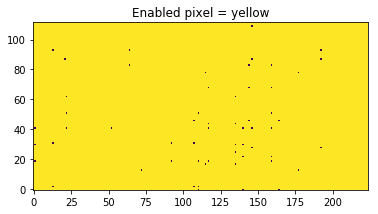

In [5]:
#### enable pixels and mask noisy pixels
chip.set_monoread()
noisy=chip.auto_mask()

mask=chip.get_pixel_status(mask=None,mode="all")
plt.imshow(chip.get_pixel_status(mask=mask,mode="preamp")[chip.fl_n,:,:],
           interpolation="none",origin="bottomleft")
plt.title("Enabled pixel = yellow");

In [31]:
chip.power_on(VDDA=1.81,VDDA_DAC=1.81,VDDD=1.81,VPC=1.81)

In [4]:
### check power status (VDDD < several mA, VDDP roughly 80mA)
chip.get_power_status()

{'BiasSF [V]': 1.0577205366842242,
 'BiasSF [mA]': 0.10075508592111837,
 'VDDA OC': False,
 'VDDA [V]': 1.7956671821821824,
 'VDDA [mA]': 27.859533837294222,
 'VDDA_DAC OC': False,
 'VDDA_DAC [V]': 1.799400513513514,
 'VDDA_DAC [mA]': 3.5493580650921066,
 'VDDD OC': False,
 'VDDD [V]': 1.8006884550898203,
 'VDDD [mA]': 0.5050023779947537,
 'VDDP OC': False,
 'VDDP [V]': 1.779907425425425,
 'VDDP [mA]': 178.84479668096134,
 'VPC [V]': 1.2995242069361277,
 'VPC [mA]': -0.5720793008976751,
 'VPCSWSF [V]': 0.5001039,
 'VPCSWSF [mA]': 0.08426042525597698}

preamp of [50,50]: True
inj of [50,50]: True
hitor of [50,50]: False


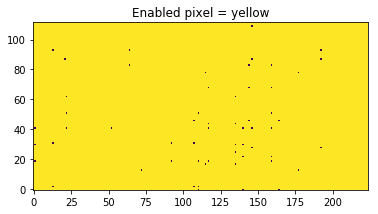

In [7]:
### select one pixel
col=50
row=50
chip.enable_injection(chip.fl_n, col, row)
#chip.enable_pixel(chip.fl_n,col,row) 
#chip.enable_hitor(chip.fl_n,col,row)
mask=chip.get_pixel_status(mask=None,mode="all")
print "preamp of [%d,%d]:"%(col,row),chip.get_pixel_status(mask=mask,mode="preamp")[chip.fl_n, col, row]
print "inj of [%d,%d]:"%(col,row),chip.get_pixel_status(mask=mask,mode="inj")[chip.fl_n, col, row]
print "hitor of [%d,%d]:"%(col,row),chip.get_pixel_status(mask=mask,mode="mon")[chip.fl_n, col, row]
plt.imshow(chip.get_pixel_status(mask=mask,mode="preamp")[chip.fl_n,:,:],
           interpolation="none",origin="bottomleft")
plt.title("Enabled pixel = yellow");

In [8]:
### (optional) inject 1 pixel. it is good idea to run this once/twice.
chip.set_inj_all(inj_n=1000,inj_phase=0)
#chip.reset_ibias()
chip.set_monoread()
chip.inject()
time.sleep(1)
dat=chip.interpret_data(chip['fifo'].get_data())
print "n of data", len(dat)
if len(dat)!=0:
    uni,cnt=np.unique(dat[["col",'row']], return_counts=True)
    arg=np.argsort(cnt)
    for a in arg[::-1]:
        print uni[a],cnt[a]

2019-12-09 19:15:53,949 [INFO ] (MainThread) vl = 1.00862204724V
2019-12-09 19:15:53,951 [INFO ] (MainThread) vh = 1.50468503937V


n of data 1000
(50, 50) 1000


2019-12-09 19:16:07,065 [INFO ] (MainThread) vl = 1.00862204724V
2019-12-09 19:16:07,067 [INFO ] (MainThread) vh = 1.50468503937V
2019-12-09 19:16:07,085 [INFO ] (MainThread) Initializing ThScan
2019-12-09 19:16:07,491 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2995242069361277, 'VDDA_DAC [mA]': 3.5493580650921066, 'VDDP [V]': 1.779907425425425, 'VDDP OC': False, 'VDDA [mA]': 23.80723799040404, 'VDDD [V]': 1.7996908592814371, 'VDDA_DAC OC': False, 'VDDD [mA]': 0.5050023779947537, 'VPCSWSF [V]': 0.5006029934098852, 'VDDP [mA]': 178.84479668096134, 'BiasSF [V]': 1.0587213072241242, 'VDDD OC': False, 'VPC [mA]': 0.2645740450230944, 'VPCSWSF [mA]': -0.07711125328228922, 'VDDA [V]': 1.7946697307307309, 'VDDA OC': False, 'VDDA_DAC [V]': 1.7984034324324327, 'BiasSF [mA]': 0.10075508592111837}
2019-12-09 19:16:12,718 [INFO ] (MainThread) Temperature (C): 28.644224
2019-12-09 19:16:12,752 [INFO ] (MainThread) Temperature (C): 28.605883
2019-12-09 19:16:12,798 [INFO ] (MainThread) Temperat

0 164165 100.000% 5.183s 54722hits 0errs
data (inj_n 1000,inj_loop 35): INJ=35000 MONO=19722 MON=0


/anaconda3/lib/python2.7/site-packages/numba/dataflow.py:390: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)
/anaconda3/lib/python2.7/site-packages/numba/ir_utils.py:1969: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'injlist' of function '_build_inj'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../tjmonopix/analysis/event_builder_inj.py", line 24:
@njit
def _build_inj(dat, injlist, thlist, phaselist, rowlist, inj_period, inj_n, mode, buf, scan_param_id, pre_inj, inj_id, inj_cnt):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/anaconda3/lib/python2.7/site-packages/numba/ir_utils.py:1969: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: t

0 54722 100.000% 1.460s 19722hits 0errs
delete_noninjected from 19722 to 19722 to 19722 100.000 percent
delete_cetainvalue from 19722 to 19722 100.000 percent
fit mu=2.952e+02(14.7624DU) sigma=1.938e+01(0.9688DU)


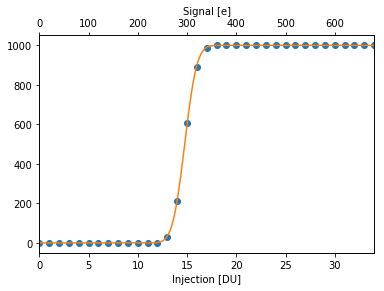

In [9]:
### S-curve
chip.set_inj_all(inj_n=1000,inj_phase=0)
reload(th_scan)
scan=th_scan.ThScan(chip)
scan.start(rowlist=np.arange(row,row+1,1), ## list of rows
           collist=np.arange(col,col+1,1), ## list of columns
           n_mask_col=1,                   ## maximum number of columns which are injected at once
           injlist=np.arange(0,35)         ## scan values of test pulse amplitude in DU
           )                               ## do not change
scan.analyze(scan.output_filename)
scan.stop()
fraw=scan.output_filename+'.h5'
fev=fraw[:-7]+'ev.h5'

with tb.open_file(fev) as f:
    cnts=f.root.Cnts[:]
    inj=f.root.ScurveFit.attrs.injlist
    fit=f.root.ScurveFit[:]
fig,ax=plt.subplots(ncols=1,nrows=1,sharey=True)
ax=[ax]
cnts=cnts[np.bitwise_and(cnts['col']==col,cnts['row']==row)]
fit=fit[np.bitwise_and(fit['col']==col,fit['row']==row)][0]
cnt=np.zeros(len(inj))
for c in cnts:
    cnt[np.argwhere(inj==c["inj"])[0][0]]=c['cnt']
x,y=tjmonopix.analysis.utils.scurve_from_fit(th=inj,n=500,
        reverse=False,A_fit=fit["A"],mu_fit=fit["mu"],sigma_fit=fit['sigma'])
ax[0].plot(inj,cnt,"o")
ax[0].plot(x,y,"-")
ax2=ax[0].twiny()
ax[0].set_xbound(np.min(inj),np.max(inj))
ax2.set_xbound(np.min(inj)*DUtoe,np.max(inj)*DUtoe)
ax[0].set_xlabel("Injection [DU]")
ax2.set_xlabel("Signal [e]")
print "fit mu=%.3e(%.4fDU)"%(fit["mu"]*DUtoe,fit["mu"]),
print "sigma=%.3e(%.4fDU)"%(fit["sigma"]*DUtoe,fit["sigma"])

In [10]:
## Threshold scan 1col=~1.5min
chip.set_inj_all(inj_n=100,inj_phase=0)
reload(th_scan)
scan=th_scan.ThScan(chip)
scan.start(rowlist=np.arange(0,224,1), ## list of rows
           collist=np.arange(0,112,10), ## list of columns change here (0,112,1) for full scan
           n_mask_col=1,                   ## max number of columns to be injected
           injlist=np.arange(0,35),        ## scan values of test pulse amplitude in DU
           debug=4)                        
scan.analyze(scan.output_filename)
scan.stop()
fraw=scan.output_filename+'.h5'
fev=fraw[:-7]+'ev.h5'

2019-12-09 19:16:51,058 [INFO ] (MainThread) vl = 1.00862204724V
2019-12-09 19:16:51,062 [INFO ] (MainThread) vh = 1.50468503937V
2019-12-09 19:16:51,070 [INFO ] (MainThread) Initializing ThScan
2019-12-09 19:16:51,456 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2995242069361277, 'VDDA_DAC [mA]': 3.5493580650921066, 'VDDP [V]': 1.779907425425425, 'VDDP OC': False, 'VDDA [mA]': 23.80723799040404, 'VDDD [V]': 1.7996908592814371, 'VDDA_DAC OC': False, 'VDDD [mA]': 0.5050023779947537, 'VPCSWSF [V]': 0.5001039, 'VDDP [mA]': 178.84479668096134, 'BiasSF [V]': 1.0592216924940743, 'VDDD OC': False, 'VPC [mA]': 0.3674085254882964, 'VPCSWSF [mA]': -0.05872713800577789, 'VDDA [V]': 1.7946697307307309, 'VDDA OC': False, 'VDDA_DAC [V]': 1.7984034324324327, 'BiasSF [mA]': 0.10025097583624568}
2019-12-09 19:16:51,502 [INFO ] (MainThread) Temperature (C): 28.798231
2019-12-09 19:16:51,542 [INFO ] (MainThread) Temperature (C): 28.609665
2019-12-09 19:16:51,582 [INFO ] (MainThread) Temperature (C): 

0 39343517 100.000% 0.722s 13114506hits 0errs
data (inj_n 100,inj_loop 7840): INJ=7151619 MONO=2848381 MON=0
0 9999999 76.251% 0.959s 2848378hits 0errs
data (inj_n 100,inj_loop 7840): INJ=2256382 MONO=858125 MON=0
9999999 3114507 100.000% 1.343s 858124hits 0errs
delete_noninjected from 3706502 to 3706383 to 3706383 99.997 percent
delete_cetainvalue from 3706383 to 3706383 100.000 percent


2676 pixels sends data


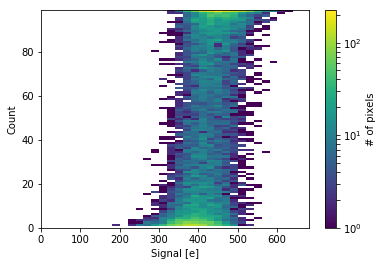

In [11]:
# superinposed s-curves

with tb.open_file(fev) as f:
    cnts=f.root.Cnts[:]
    inj=f.root.ScurveFit.attrs.injlist

fig,ax=plt.subplots(ncols=1,nrows=1,sharey=True)
hist=ax.hist2d(cnts['inj']*DUtoe,cnts['cnt'], bins=[inj*DUtoe,np.arange(100)],norm=norm)
cb=fig.colorbar(hist[3], ax=ax)
cb.set_label("# of pixels")
ax.set_ylabel("Count")
ax.set_xlabel("Signal [e]");
print "%d pixels sends data"%len(np.unique(cnts[["col","row"]]))

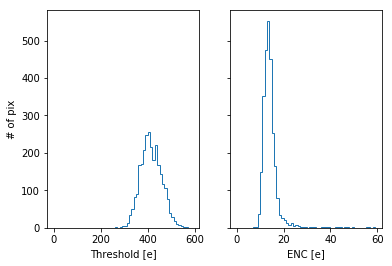

In [12]:
# threshold, noise distribution

with tb.open_file(fev) as f:
    fit=f.root.ScurveFit[:]
fig,ax=plt.subplots(ncols=2,nrows=1,sharey=True)
ax[0].hist(fit['mu']*DUtoe,bins=np.arange(0,30,0.5)*DUtoe,histtype="step")
ax[1].hist(fit['sigma']*DUtoe,bins=np.arange(0,3,0.05)*DUtoe,histtype="step")
ax[0].set_ylabel("# of pix")
ax[0].set_xlabel("Threshold [e]")
ax[1].set_xlabel("ENC [e]");

2019-12-09 19:33:16,893 [INFO ] (MainThread) Initializing SourceScan
2019-12-09 19:33:17,299 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2995242069361277, 'VDDA_DAC [mA]': 3.5493580650921066, 'VDDP [V]': 1.779907425425425, 'VDDP OC': False, 'VDDA [mA]': 23.80723799040404, 'VDDD [V]': 1.8006884550898203, 'VDDA_DAC OC': False, 'VDDD [mA]': 0.5050023779947537, 'VPCSWSF [V]': 0.5001039, 'VDDP [mA]': 178.84479668096134, 'BiasSF [V]': 1.0597220777640242, 'VDDD OC': False, 'VPC [mA]': 0.09734321514036305, 'VPCSWSF [mA]': 0.15830755623081433, 'VDDA [V]': 1.7946697307307309, 'VDDA OC': False, 'VDDA_DAC [V]': 1.799400513513514, 'BiasSF [mA]': 0.10075508592111837}
2019-12-09 19:33:17,351 [INFO ] (MainThread) Temperature (C): 29.413870
2019-12-09 19:33:17,379 [INFO ] (MainThread) Temperature (C): 29.584032
2019-12-09 19:33:17,417 [INFO ] (MainThread) Temperature (C): 29.753334
2019-12-09 19:33:17,461 [INFO ] (MainThread) Temperature (C): 29.584032
2019-12-09 19:33:17,501 [INFO ] (MainThread) 

2019-12-09 19:33:29,371 [INFO ] (MainThread) time=10s dat=0 rate=0.000k/s temp=29.56C
2019-12-09 19:33:30,419 [INFO ] (MainThread) Temperature (C): 29.393919
2019-12-09 19:33:30,451 [INFO ] (MainThread) Temperature (C): 29.564059
2019-12-09 19:33:30,485 [INFO ] (MainThread) Temperature (C): 29.584032
2019-12-09 19:33:30,518 [INFO ] (MainThread) Temperature (C): 29.544103
2019-12-09 19:33:30,547 [INFO ] (MainThread) Temperature (C): 29.544103
2019-12-09 19:33:30,576 [INFO ] (MainThread) Temperature (C): 29.564059
2019-12-09 19:33:30,606 [INFO ] (MainThread) Temperature (C): 29.564059
2019-12-09 19:33:30,639 [INFO ] (MainThread) Temperature (C): 29.564059
2019-12-09 19:33:30,688 [INFO ] (MainThread) Temperature (C): 29.393919
2019-12-09 19:33:30,733 [INFO ] (MainThread) Temperature (C): 29.564059
2019-12-09 19:33:30,735 [INFO ] (MainThread) time=12s dat=0 rate=0.000k/s temp=29.53C
2019-12-09 19:33:31,779 [INFO ] (MainThread) Temperature (C): 29.544103
2019-12-09 19:33:31,807 [INFO ] (Mai

2019-12-09 19:33:44,478 [INFO ] (MainThread) Temperature (C): 29.544103
2019-12-09 19:33:44,520 [INFO ] (MainThread) Temperature (C): 29.564059
2019-12-09 19:33:44,557 [INFO ] (MainThread) Temperature (C): 29.564059
2019-12-09 19:33:44,593 [INFO ] (MainThread) Temperature (C): 29.713360
2019-12-09 19:33:44,633 [INFO ] (MainThread) Temperature (C): 29.544103
2019-12-09 19:33:44,673 [INFO ] (MainThread) Temperature (C): 29.393919
2019-12-09 19:33:44,710 [INFO ] (MainThread) Temperature (C): 29.544103
2019-12-09 19:33:44,747 [INFO ] (MainThread) Temperature (C): 29.713360
2019-12-09 19:33:44,784 [INFO ] (MainThread) Temperature (C): 29.733338
2019-12-09 19:33:44,786 [INFO ] (MainThread) time=26s dat=9 rate=0.000k/s temp=29.60C
2019-12-09 19:33:45,832 [INFO ] (MainThread) Temperature (C): 29.564059
2019-12-09 19:33:45,863 [INFO ] (MainThread) Temperature (C): 29.733338
2019-12-09 19:33:45,896 [INFO ] (MainThread) Temperature (C): 29.544103
2019-12-09 19:33:45,928 [INFO ] (MainThread) Tempe

2019-12-09 19:34:57,374 [INFO ] (MainThread) Temperature (C): 29.584032
2019-12-09 19:34:57,402 [INFO ] (MainThread) Temperature (C): 29.584032
2019-12-09 19:34:57,437 [INFO ] (MainThread) Temperature (C): 29.753334
2019-12-09 19:34:57,467 [INFO ] (MainThread) Temperature (C): 29.753334
2019-12-09 19:34:57,497 [INFO ] (MainThread) Temperature (C): 29.604023
2019-12-09 19:34:57,530 [INFO ] (MainThread) Temperature (C): 29.753334
2019-12-09 19:34:57,561 [INFO ] (MainThread) Temperature (C): 29.564059
2019-12-09 19:34:57,562 [INFO ] (MainThread) time=99s dat=30 rate=0.000k/s temp=29.65C
2019-12-09 19:34:58,935 [WARNI] (MainThread) FIFO stopped due to timeout
2019-12-09 19:34:58,959 [INFO ] (MainThread) Stopped FIFO readout
2019-12-09 19:34:58,976 [INFO ] (MainThread) Recived words: 30
2019-12-09 19:34:58,978 [INFO ] (MainThread) Data queue size: 0
2019-12-09 19:34:58,980 [INFO ] (MainThread) SRAM FIFO size: 0
2019-12-09 19:34:58,983 [INFO ] (MainThread) Channel:                     TDC | 

/Users/MGranado/tjmonopix-daq/examples/output_data/20191209_193316_source_scan.h5
0 29 100.000% 2.944s 10hits


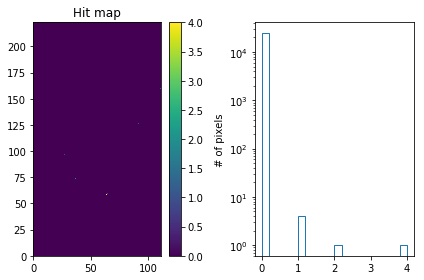

In [13]:
## noise occupancy
reload(source_scan)
scan=source_scan.SourceScan(dut=chip)
scan.start(scan_time=100,                                ## scan time in seconds
           with_mon=False,with_rx1=False,with_tlu=False) ## do not change
fhit=scan.analyze(scan.output_filename,event_build="none",clusterize=False)
scan.stop()
with tb.open_file(fhit) as f:
    hits=f.root.Hits[:]
fig,ax=plt.subplots(ncols=2,nrows=1)
hist=ax[0].hist2d(hits['col'],hits['row'],bins=[np.arange(0,112),np.arange(0,224)]);
fig.colorbar(hist[3],ax=ax[0])
ax[1].hist(np.reshape(hist[0],[-1]),histtype="step",bins=20)
ax[1].set_yscale("log")
ax[0].set_title("Hit map");
ax[1].set_ylabel("# of pixels");
fig.tight_layout()

# Source scan

In [3]:
### (optional) load setting from confiuration file
with open("Mod1W7R19.yaml") as f:
    conf=yaml.safe_load(f)
chip=tjmonopix.tjmonopix.TJMonoPix(
    conf=conf['dut']['file'],
    no_power_reset=True)
chip.init()    
    
chip.default_conf()
chip.switch_flavor(conf["dut"]['flavor'])
chip.enable_pixel(chip.fl_n,col=-1,row=-1,mask=conf['mask'])
chip.reset_ibias()

chip.set_vreset_dacunits(conf['dut']['vreset_dacunits'],1) #
chip.set_icasn_dacunits(conf['dut']['icasn_dacunits'],1) 
chip.set_ireset_dacunits(conf['dut']['ireset_dacunits']['value'],conf['dut']['ireset_dacunits']['mode'],1)
chip.set_ithr_dacunits(conf['dut']['ithr_dacunits'],1)
chip.set_idb_dacunits(conf['dut']['idb_dacunits'],1)
chip.set_ibias_dacunits(conf['dut']['ibias_dacunits'],1)
chip.reset_ibias()

2019-12-10 10:31:16,550 [INFO ] (MainThread) GPAC: skipping power reset
2019-12-10 10:31:18,029 [INFO ] (MainThread) Found adapter card: General Purpose Analog Card (GPAC) with ID 32
2019-12-10 10:31:18,140 [INFO ] (MainThread) Found board 0 running firmware version 0.0
2019-12-10 10:31:18,267 [INFO ] (MainThread) ibias = 45
2019-12-10 10:31:18,268 [INFO ] (MainThread) ibias = 503.125nA
2019-12-10 10:31:18,689 [INFO ] (MainThread) {'VPC [V]': 1.299025400998004, 'VDDA_DAC [mA]': 3.5493580650921066, 'VDDP [V]': 1.779907425425425, 'VDDP OC': False, 'VDDA [mA]': 126.12770812438102, 'VDDD [V]': 1.8006884550898203, 'VDDA_DAC OC': False, 'VDDD [mA]': 0.5050023779947537, 'VPCSWSF [V]': 0.5001039, 'VDDP [mA]': 160.5538515551933, 'BiasSF [V]': 1.0577205366842242, 'VDDD OC': False, 'VPC [mA]': -0.04942055795075047, 'VPCSWSF [mA]': 0.007659944937179725, 'VDDA [V]': 1.7946697307307309, 'VDDA OC': False, 'VDDA_DAC [V]': 1.799400513513514, 'BiasSF [mA]': 0.10075508592111837}
2019-12-10 10:31:18,691 [

In [5]:
## Fe
## online monitor
## % start_online_monitor ../tjmonopix/online_monitor.yaml

reload(source_scan)
scan=source_scan.SourceScan(dut=chip)
scan.start(scan_time=100,                                ## scan time in seconds
           with_mon=False,with_rx1=False,with_tlu=False) ## do not change
fcl=scan.analyze(scan.output_filename,event_build="token",clusterize=True)
scan.stop()

2019-12-10 10:32:18,506 [INFO ] (MainThread) Initializing SourceScan
2019-12-10 10:32:18,905 [INFO ] (MainThread) Power status: {'VPC [V]': 1.2995242069361277, 'VDDA_DAC [mA]': 3.5493580650921066, 'VDDP [V]': 1.779907425425425, 'VDDP OC': False, 'VDDA [mA]': 27.859533837294222, 'VDDD [V]': 1.7996908592814371, 'VDDA_DAC OC': False, 'VDDD [mA]': 0.5050023779947537, 'VPCSWSF [V]': 0.5001039, 'VDDP [mA]': 178.33671487191222, 'BiasSF [V]': 1.0577205366842242, 'VDDD OC': False, 'VPC [mA]': 0.15774599250099142, 'VPCSWSF [mA]': -0.07966460262624914, 'VDDA [V]': 1.7956671821821824, 'VDDA OC': False, 'VDDA_DAC [V]': 1.799400513513514, 'BiasSF [mA]': 0.10075508592111837}
2019-12-10 10:32:24,137 [INFO ] (MainThread) Temperature: 27.2 C
2019-12-10 10:32:24,204 [INFO ] (MainThread) Creating ZMQ context
2019-12-10 10:32:24,206 [INFO ] (MainThread) Creating socket connection to server tcp://127.0.0.1:5500
2019-12-10 10:32:24,208 [INFO ] (MainThread) ScanBase.start:data_send.data_send_init connected
20

/Users/MGranado/tjmonopix-daq/examples/output_data/20191210_103218_source_scan.h5


/anaconda3/lib/python2.7/site-packages/numba/dataflow.py:390: RuntimeWarning: Python2 style print partially supported.  Please use Python3 style print.
  "Python3 style print.", RuntimeWarning)


('ERROR TJMONO', 0, 0, 525931227)

('ERR TJMONO2', 1, 0, 637534217)

0 22738575 100.000% 3.100s 7579524hits
event_builder_token.build_h5() fin: /Users/MGranado/tjmonopix-daq/examples/output_data/20191210_103218_source_hit.h5
event_builder.build_h5() # of data:total=7579524 ERR=0 TLU=0 TS1=0 TS2=0 TS3=0 TJ=7579474
without flg1=7141429
event_builder.build_h5() check timestamp: increase only True
event_builder.build_h5() check flg: no strange value
event_builder.build_h5() 0.341s te_offset=54
event_builder.build_h5() calculation done 2.745s
event_builder.build_h5() 3.028s DONE
clusterize_h5() 5.25s # of clusters 7141429
clusterize_h5() 5.71s cluster_hits 100.00% saved
clusterize_h5() 5.93s clusters 100.00% saved
clusterize_h5() 6.16s DONE


In [6]:
with tb.open_file(fcl) as f:
    dat=f.root.Clusters[:]
tmp=dat[np.bitwise_and(dat['seed_column']==col,dat['seed_row']==row)]
bins=np.arange(0,0x41)
plt.hist(tmp['charge'],bins=bins,label="total charge");
plt.hist(tmp['charge'][tmp['n_hits']==1],bins=bins,label="single-pixel");
plt.xlabel("ToT (40MHz)")
plt.ylabel("Count")
plt.legend();

NameError: name 'col' is not defined

In [ ]:
## Sr with TLU
## tlu
## % pytlu -ie CH0 -io CH0 -th 30 -t 0 --timeout 0 -b 15 
reload(source_scan)
scan=source_scan.SourceScan(dut=chip)
scan.start(scan_time=100,
    with_mon=False,with_rx1=False,with_tlu=True) ## do not change
fcl=scan.analyze(scan.output_filename,event_build="token",clusterize=True)
scan.stop()
fhit=scan.output_filename[:-4]+'hit.h5'